<a href="https://colab.research.google.com/github/DabogerLiu/Titanic-Prediction/blob/master/Covid19_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [0]:
#check the old format
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
death_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

confirmed_table = confirmed_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Confirmed").fillna('').drop(['Lat', 'Long'], axis=1)
death_table = death_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Deaths").fillna('').drop(['Lat', 'Long'], axis=1)
recovered_table = recovered_df.melt(id_vars=["Province/State", "Country/Region", "Lat", "Long"], var_name="Date", value_name="Recovered").fillna('').drop(['Lat', 'Long'], axis=1)

full_table = confirmed_table.merge(death_table).merge(recovered_table)

full_table['Date'] = pd.to_datetime(full_table['Date'])
full_table

,Province/State,Country/Region,Date,Confirmed,Deaths,Recovered
0,,Afghanistan,2020-01-22,0,0,0
1,,Albania,2020-01-22,0,0,0
2,,Algeria,2020-01-22,0,0,0
3,,Andorra,2020-01-22,0,0,0
4,,Angola,2020-01-22,0,0,0
...,...,...,...,...,...,...
16486,Anguilla,United Kingdom,2020-03-30,2,0,0
16487,British Virgin Islands,United Kingdom,2020-03-30,2,0,0
16488,Turks and Caicos Islands,United Kingdom,2020-03-30,5,0,0
16489,,MS Zaandam,2020-03-30,2,0,0


In [0]:
def get_time_series(country):
    # for some countries, data is spread over several Provinces
    if full_table[full_table['Country/Region'] == country]['Province/State'].nunique() > 1:
        country_table = full_table[full_table['Country/Region'] == country]
        country_df = pd.DataFrame(pd.pivot_table(country_table, values = ['Confirmed', 'Deaths', 'Recovered'],
                              index='Date', aggfunc=sum).to_records())
        return country_df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]
    df = full_table[(full_table['Country/Region'] == country) 
                & (full_table['Province/State'].isin(['', country]))]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]


def get_time_series_province(province):
    # for some countries, data is spread over several Provinces
    df = full_table[(full_table['Province/State'] == province)]
    return df.set_index('Date')[['Confirmed', 'Deaths', 'Recovered']]

In [0]:
home = "Hebei"
home_df = get_time_series_province(home)
Xiaobao = 'Shaanxi'
XB_df = get_time_series_province(Xiaobao)
China = 'China'
China_df = get_time_series(China)

country = 'China'
df = get_time_series(country)
if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
    df.drop(df.tail(1).index,inplace=True)
df.tail(10)


,Confirmed,Deaths,Recovered
Date,,,
2020-03-21,81305,3259,71857
2020-03-22,81435,3274,72362
2020-03-23,81498,3274,72814
2020-03-24,81591,3281,73280
2020-03-25,81661,3285,73773
2020-03-26,81782,3291,74181
2020-03-27,81897,3296,74720
2020-03-28,81999,3299,75100
2020-03-29,82122,3304,75582


In [0]:
import math
def model_with_lag(N, a, alpha, lag, t):
    # we enforce N, a and alpha to be positive numbers using min and max functions
    lag = min(max(lag, -100), 100) # lag must be less than +/- 100 days 
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * (t - lag))) ** max(alpha, 0)

def model(N, a, alpha, t):
    return max(N, 0) * (1 - math.e ** (min(-a, 0) * t)) ** max(alpha, 0)

model_index = 0

def model_loss(params):
    N, a, alpha = params
    model_x = []
    r = 0
    for t in range(len(df)):
        r += (model(N, a, alpha, t) - df.iloc[t, model_index]) ** 2
    
    return math.sqrt(r) 


In [0]:
import numpy as np
from scipy.optimize import minimize
use_lag_model = False
if use_lag_model:
    opt = minimize(model_loss, x0=np.array([200000, 0.05, 15, 0]), method='Nelder-Mead', tol=1e-5).x
else:
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
opt_deaths

array([2.27818019e+05, 1.19979949e-04, 8.45980744e-01])

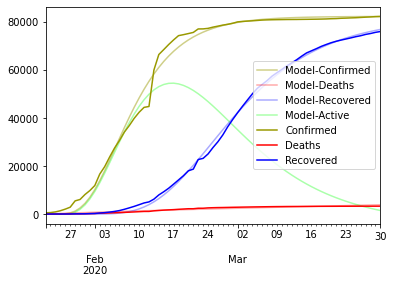

In [0]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 

model_x = []
for t in range(len(df)):
    model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
model_sim = pd.DataFrame(model_x, dtype=int)
model_sim.set_index(0, inplace=True)
model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([model_sim, df], axis=1).plot(color = plot_color)
plt.show()

China COVID-19 Prediction


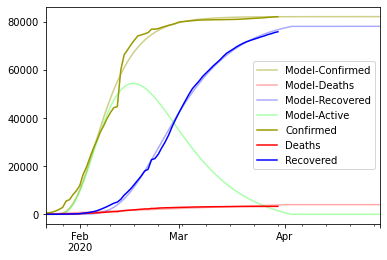

In [0]:
import datetime
start_date = df.index[0]
n_days = len(df) + 30
extended_model_x = []
last_row = []

isValid = True
last_death_rate = 0

for t in range(n_days):
    extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
    
    #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
    if (t > len(df)):
        last_row = extended_model_x[-1]
        if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.12):
            if (isValid):
                last_row2 = extended_model_x[-2]
                last_death_rate = last_row2[2]/last_row2[1]
                isValid = False

        if (last_row[2] > last_row[1]*0.05):
            last_row[2] = last_row[1]*last_death_rate
            
        if (last_row[2] + last_row[3] > last_row[1]):
            last_row[2] = last_row[1]*last_death_rate
            last_row[3] = last_row[1]*(1-last_death_rate)

extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
extended_model_sim.set_index(0, inplace=True)

extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']
extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0

plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

pd.concat([extended_model_sim, df], axis=1).plot(color = plot_color)
print('China COVID-19 Prediction')
plt.show()

World COVID-19 Prediction (With China Data)


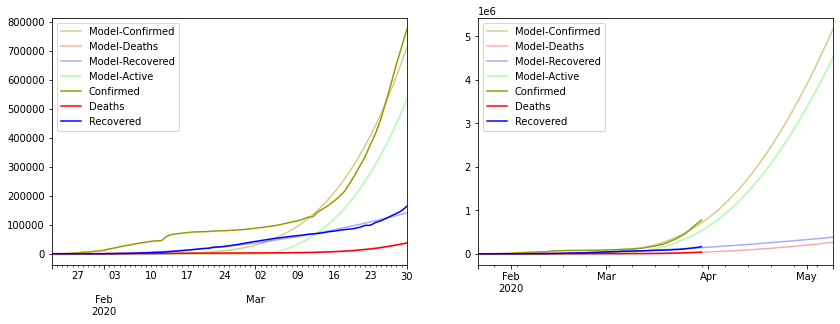

In [0]:
def display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(len(df)):
        model_x.append([df.index[t], model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
                    
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    model_sim = pd.DataFrame(model_x, dtype=int)
    model_sim.set_index(0, inplace=True)
    model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    model_sim['Model-Active'] = model_sim['Model-Confirmed'] - model_sim['Model-Deaths'] - model_sim['Model-Recovered']
    model_sim.loc[model_sim['Model-Active']<0,'Model-Active'] = 0
    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

    return pd.concat([model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)

def display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax):
    start_date = df.index[0]
    n_days = len(df) + 40
    extended_model_x = []
    
    isValid = True
    last_death_rate = 0
    
    for t in range(n_days):
        extended_model_x.append([start_date + datetime.timedelta(days=t), model(*opt_confirmed, t), model(*opt_deaths, t), model(*opt_recovered, t)])
        
        #if deaths + recovered > confirmed or deaths rate > 5%, maybe not valid
        if (t > len(df)):
            last_row = extended_model_x[-1]
            if (last_row[2] + last_row[3] > last_row[1]) or (last_row[2] > last_row[1]*0.05):
                if (isValid):
                    last_row2 = extended_model_x[-2]
                    last_death_rate = last_row2[2]/last_row2[1]
                    isValid = False
            
            if (last_row[2] > last_row[1]*0.05):
                last_row[2] = last_row[1]*last_death_rate
                    
            if (last_row[2] + last_row[3] > last_row[1]):
                last_row[2] = last_row[1]*last_death_rate
                last_row[3] = last_row[1]*(1-last_death_rate)
                
                
    extended_model_sim = pd.DataFrame(extended_model_x, dtype=int)
    extended_model_sim.set_index(0, inplace=True)
    extended_model_sim.columns = ['Model-Confirmed', 'Model-Deaths', 'Model-Recovered']

    extended_model_sim['Model-Active'] = extended_model_sim['Model-Confirmed'] - extended_model_sim['Model-Deaths'] - extended_model_sim['Model-Recovered']
    
    extended_model_sim.loc[extended_model_sim['Model-Active']<0,'Model-Active'] = 0
    plot_color = ['#99990077', '#FF000055', '#0000FF55', '#00FF0055', '#999900FF', '#FF0000FF', '#0000FFFF', '#00FF00FF']

    return pd.concat([extended_model_sim, df], axis=1).plot(ax=ax, figsize=(14, 10), color = plot_color)


def opt_display_model(df, stats):
    # if the last data point repeats the previous one, or is lower, drop it
    if len(df) > 1 and df.iloc[-2,0] >= df.iloc[-1,0]:
        df.drop(df.tail(1).index,inplace=True)
    global model_index
    model_index = 0
    opt_confirmed = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 1
    opt_deaths = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    model_index = 2
    opt_recovered = minimize(model_loss, x0=np.array([200000, 0.05, 15]), method='Nelder-Mead', tol=1e-5).x
    if min(opt_confirmed) > 0:
        stats.append([country, *opt_confirmed, *opt_deaths, *opt_recovered])
        n_plot = len(stats)
        plt.figure(1)
        ax1 = plt.subplot(221)
        display_fit(df, opt_confirmed, opt_deaths, opt_recovered, ax1)
        ax2 = plt.subplot(222)
        display_extended_curve(df, opt_confirmed, opt_deaths, opt_recovered, ax2)
        plt.show()


stats = []

df = full_table[['Province/State','Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']].groupby('Date').sum()
print('World COVID-19 Prediction (With China Data)')
opt_display_model(df, stats)

World COVID-19 Prediction(Without China Data)


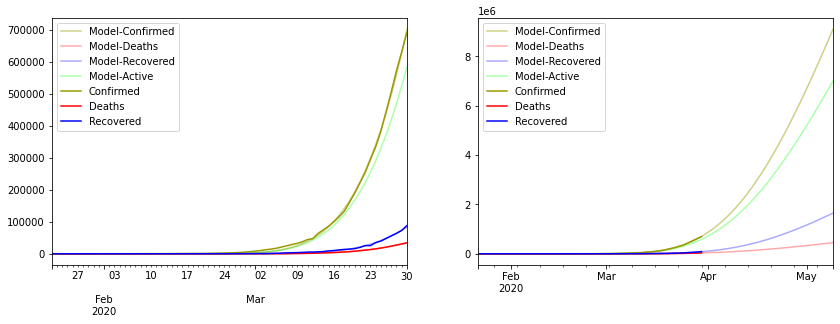

In [0]:
stats = []

df = full_table[full_table['Country/Region'] != 'China'][['Province/State','Country/Region', 'Date', 'Confirmed', 'Deaths', 'Recovered']].groupby('Date').sum()
print('World COVID-19 Prediction(Without China Data)')
opt_display_model(df, stats)

Hebei COVID-19 Prediction


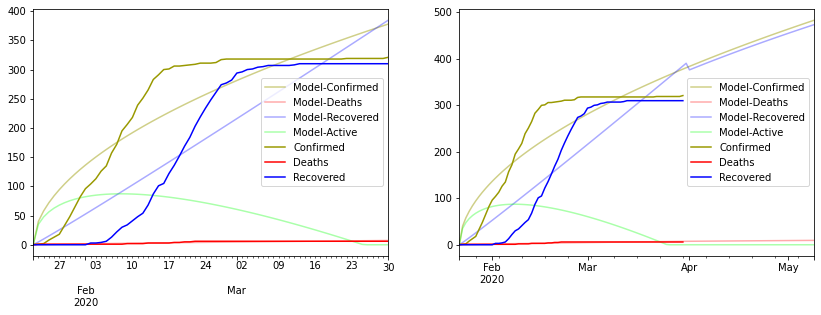

Shanghai COVID-19 Prediction


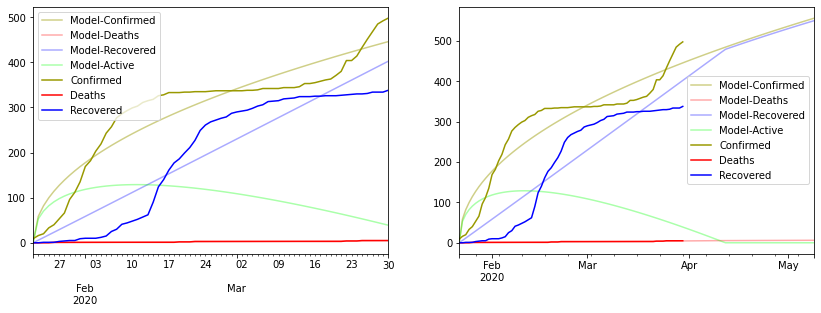

Shaanxi COVID-19 Prediction


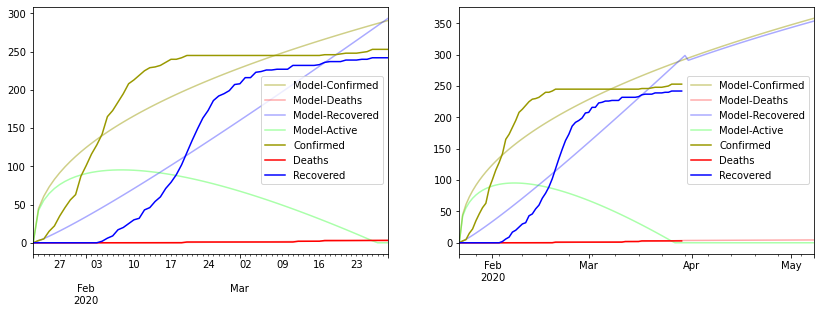

In [153]:
stats = []

# Province Specify
for Province in ['Hebei', 'Shanghai','Shaanxi']:
    df = get_time_series_province(Province)
    print('{} COVID-19 Prediction'.format(Province))
    opt_display_model(df, stats)

Singapore COVID-19 Prediction


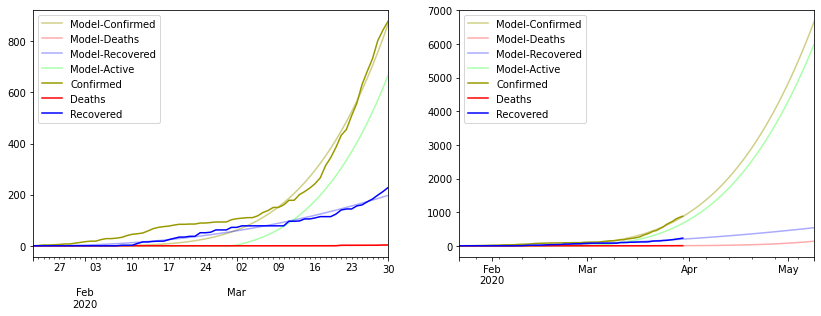

Russia COVID-19 Prediction


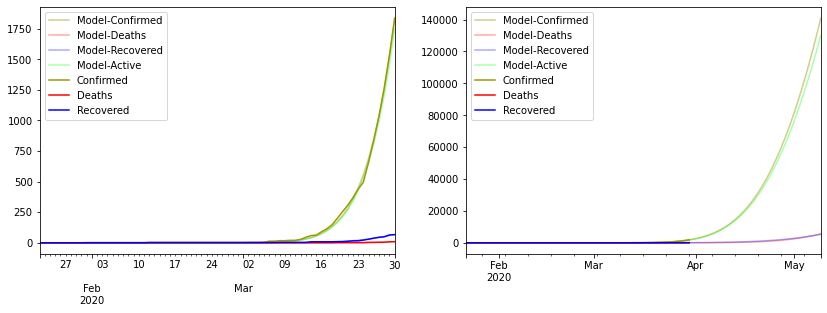

New Zealand COVID-19 Prediction


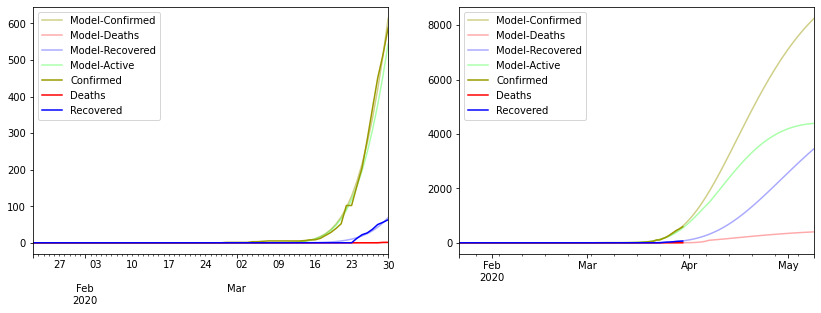

United Kingdom COVID-19 Prediction


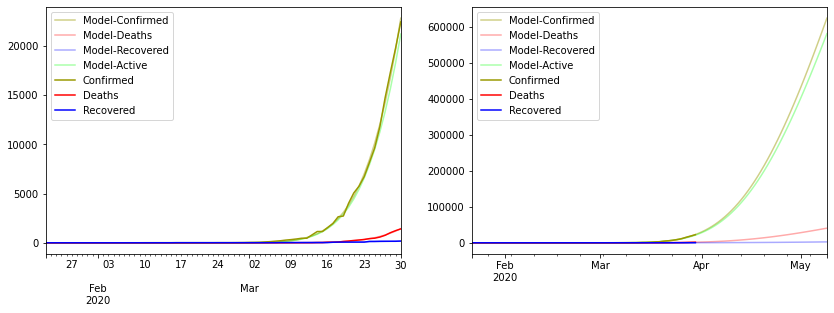

China COVID-19 Prediction


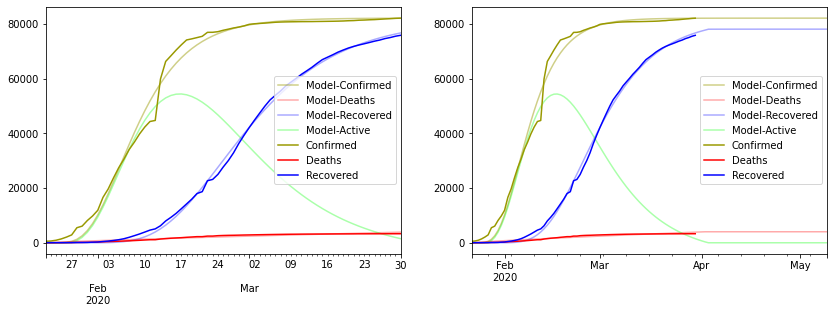

In [163]:
# Country Specify
stats = []
for country in ['Singapore', 'Russia', 'New Zealand', 'United Kingdom','China']:
# for country in ['Sweden']:
    df = get_time_series(country)

    print('{} COVID-19 Prediction'.format(country))
    
    opt_display_model(df, stats)

Australia COVID-19 Prediction


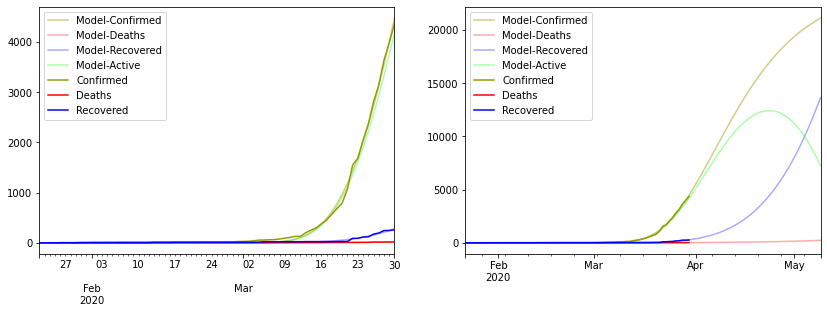

Austria COVID-19 Prediction


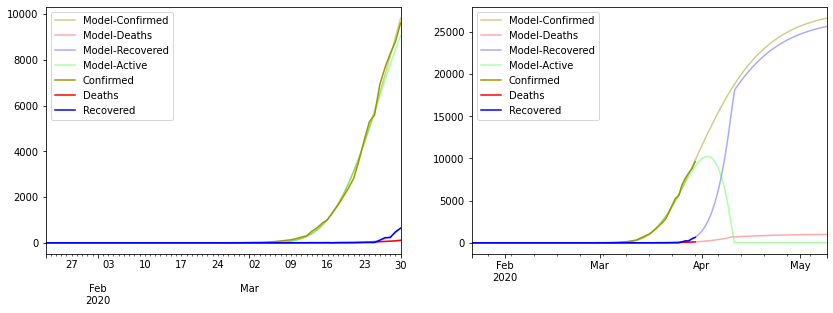

Belgium COVID-19 Prediction


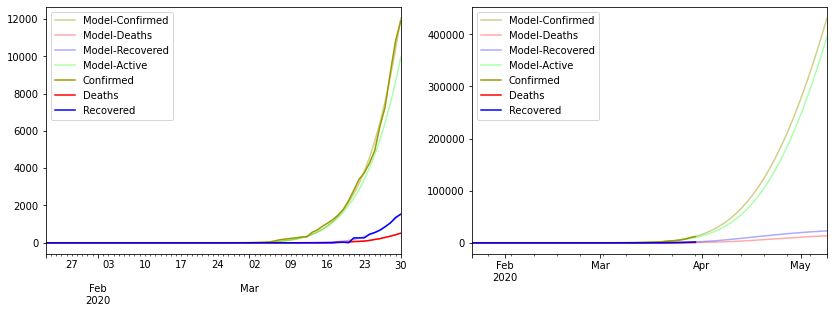

Brazil COVID-19 Prediction


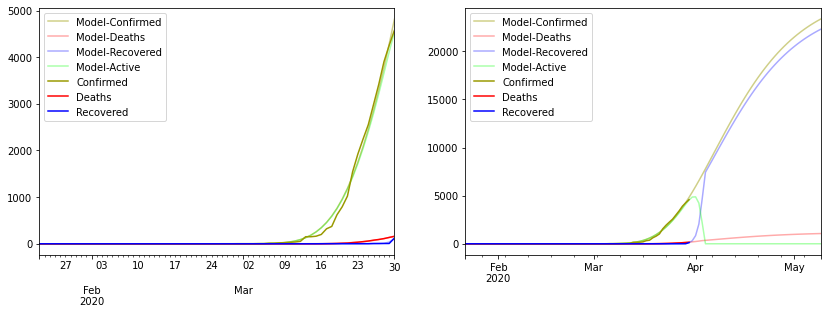

Chile COVID-19 Prediction


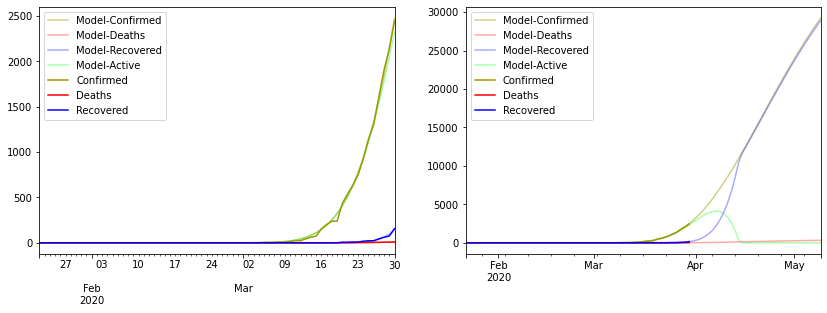

China COVID-19 Prediction


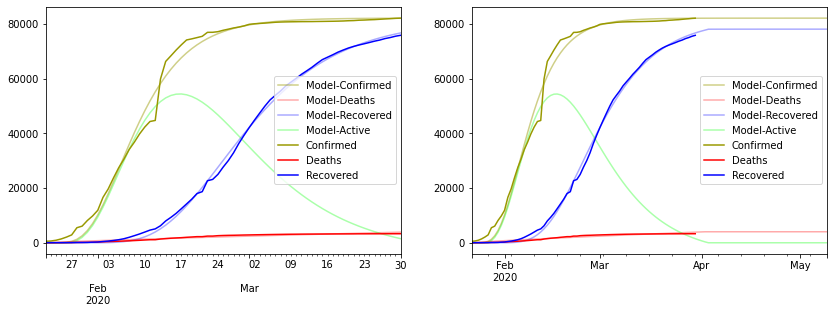

Czechia COVID-19 Prediction


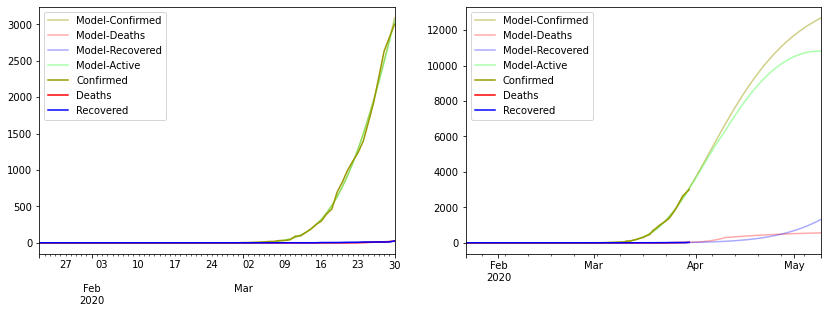

Denmark COVID-19 Prediction


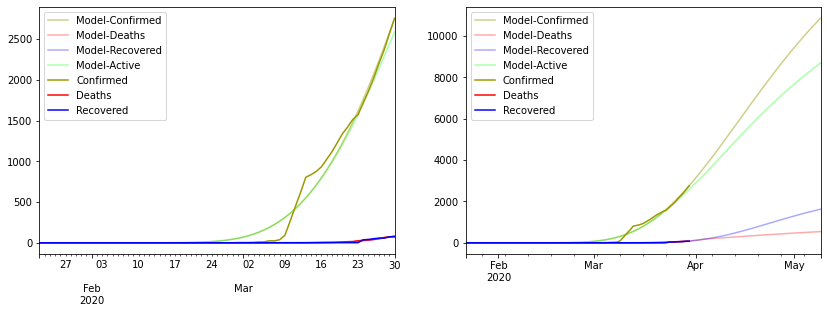

Ecuador COVID-19 Prediction


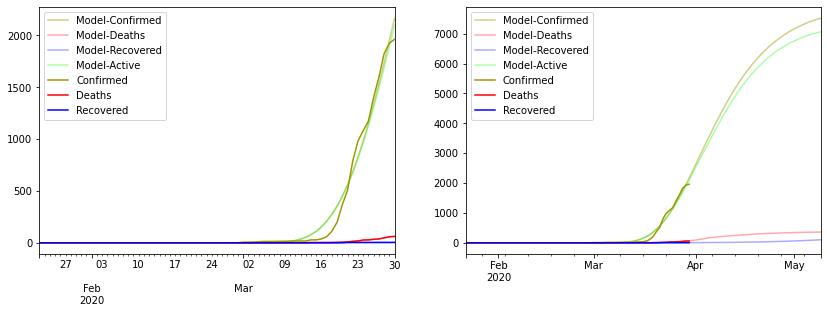

Finland COVID-19 Prediction


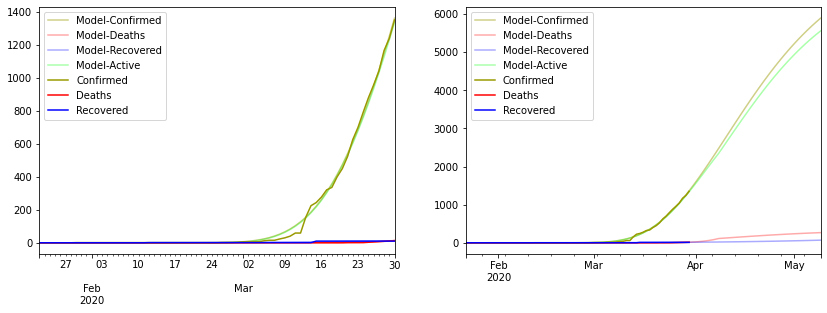

France COVID-19 Prediction


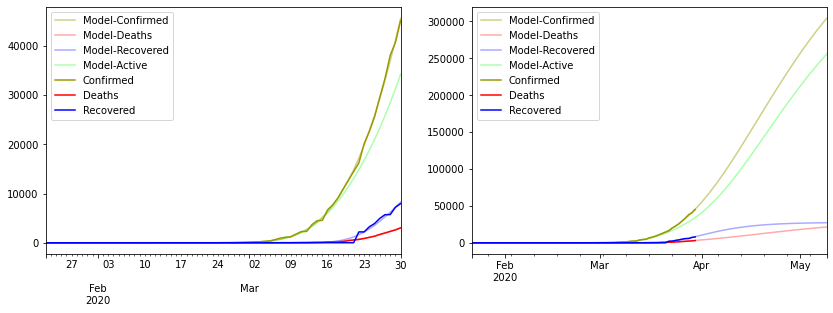

Germany COVID-19 Prediction


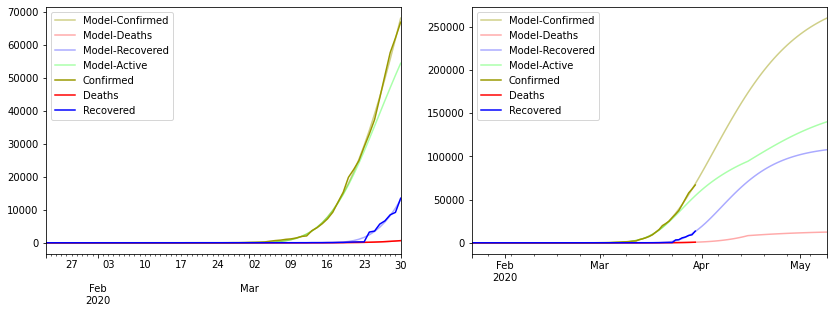

Greece COVID-19 Prediction


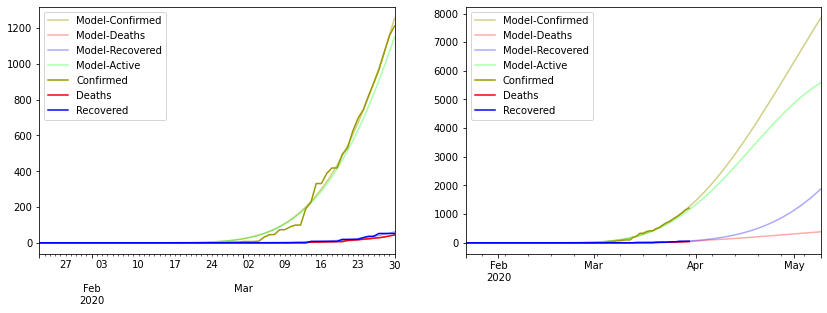

Iceland COVID-19 Prediction


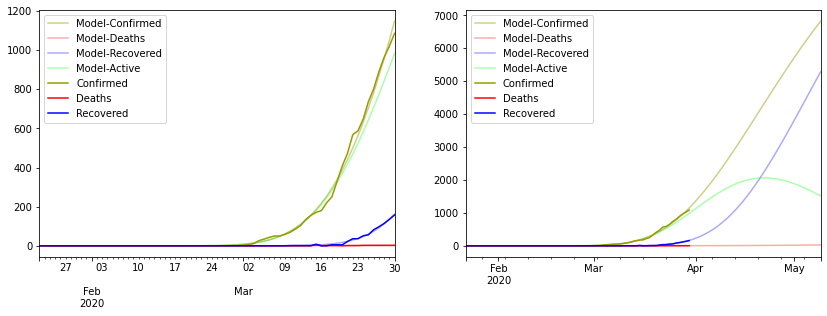

India COVID-19 Prediction


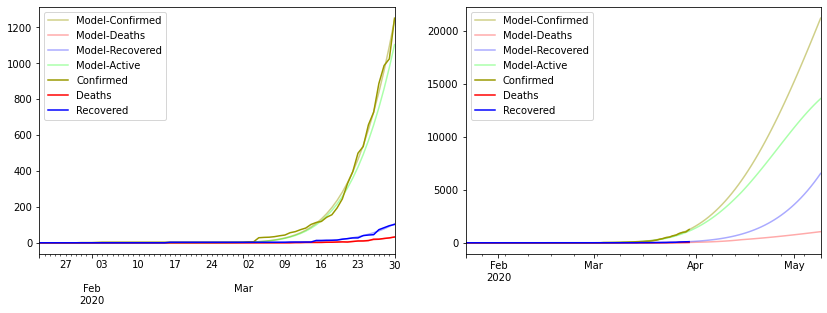

Indonesia COVID-19 Prediction


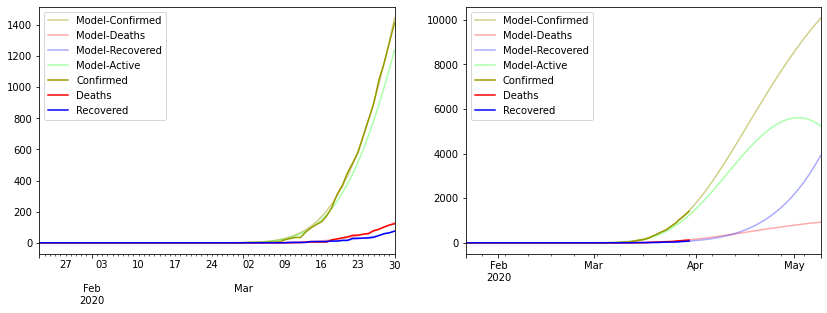

Iran COVID-19 Prediction


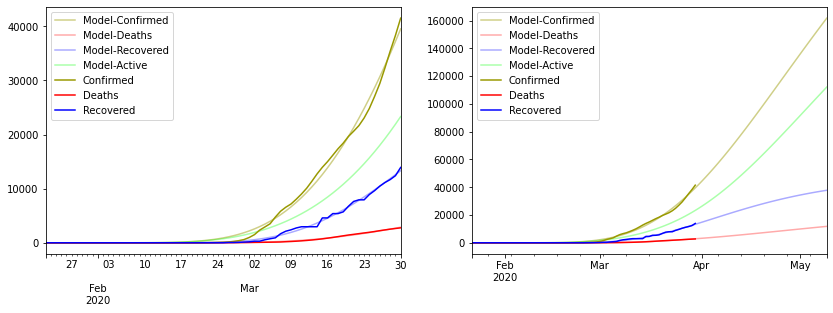

Ireland COVID-19 Prediction


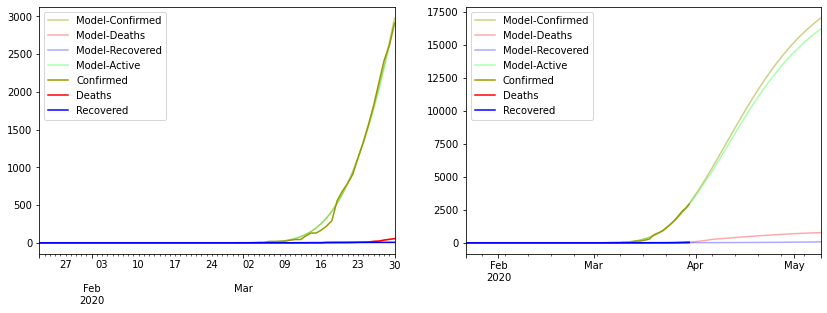

Israel COVID-19 Prediction


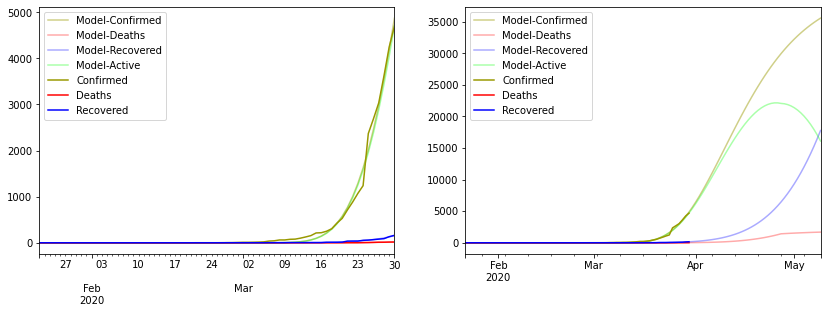

Italy COVID-19 Prediction


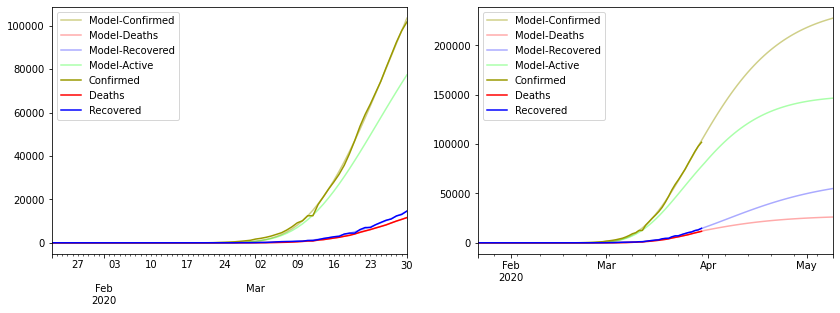

Japan COVID-19 Prediction


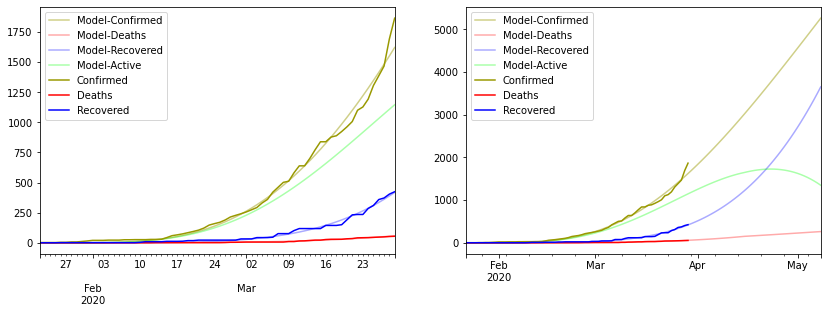

Korea, South COVID-19 Prediction


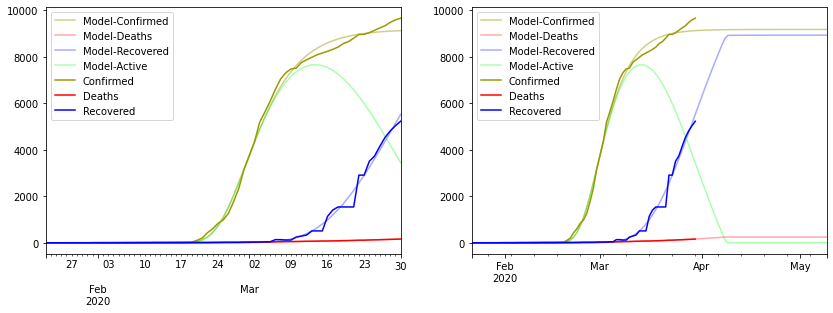

Luxembourg COVID-19 Prediction


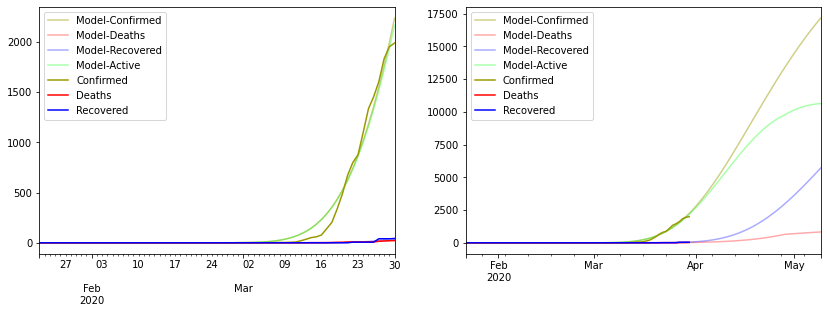

Malaysia COVID-19 Prediction


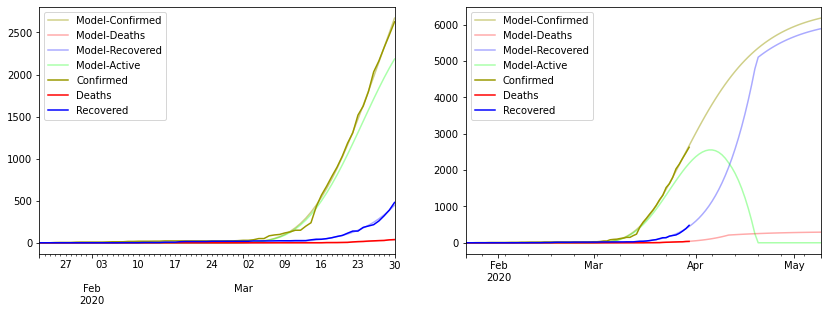

Netherlands COVID-19 Prediction


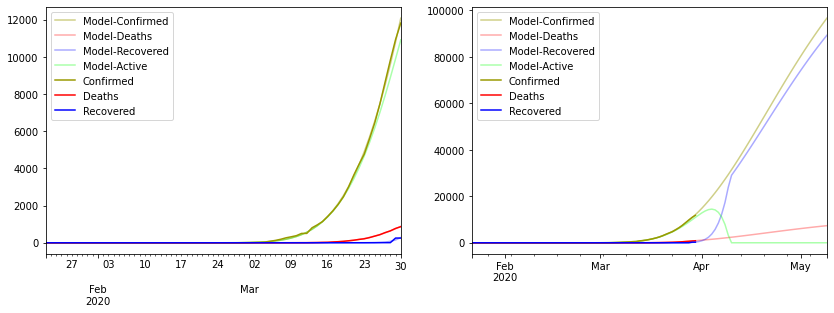

Norway COVID-19 Prediction


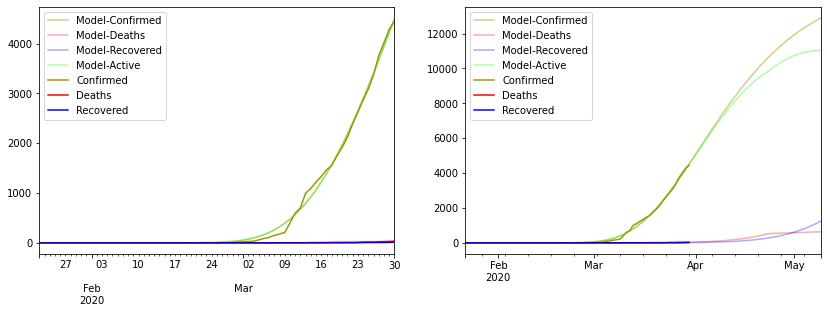

Pakistan COVID-19 Prediction


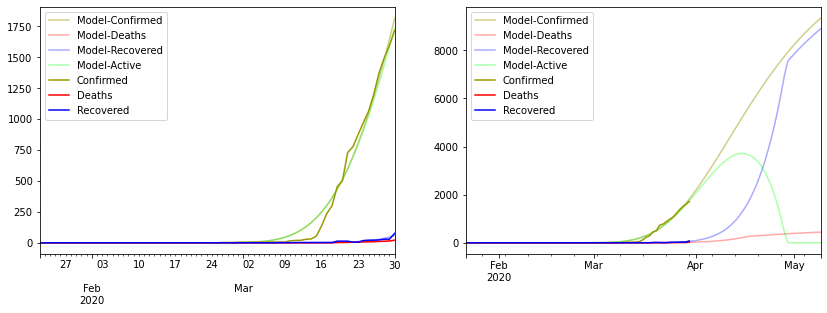

Philippines COVID-19 Prediction


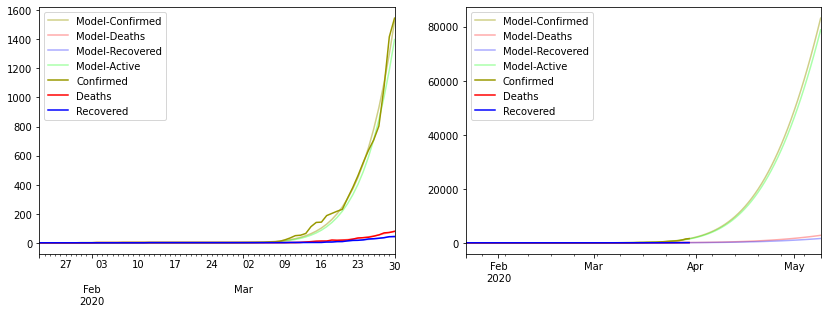

Poland COVID-19 Prediction


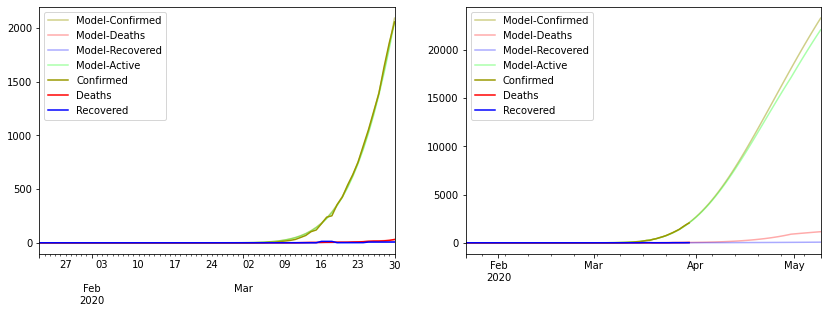

Portugal COVID-19 Prediction


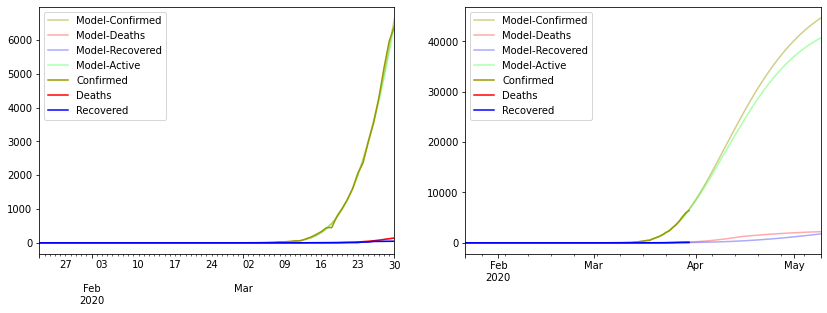

Romania COVID-19 Prediction


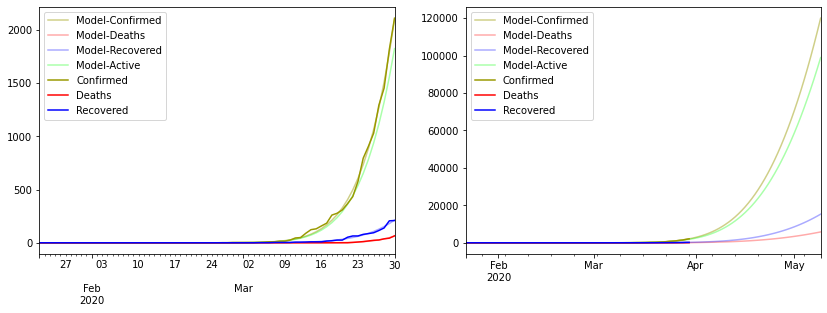

Russia COVID-19 Prediction


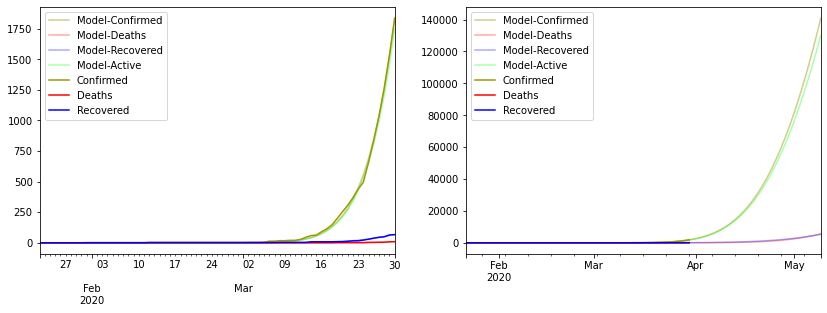

Saudi Arabia COVID-19 Prediction


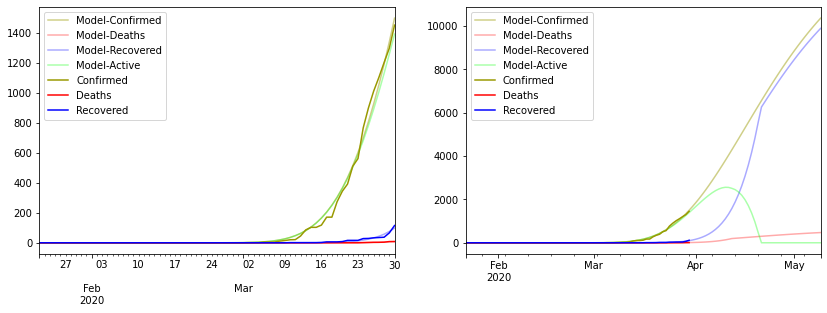

South Africa COVID-19 Prediction


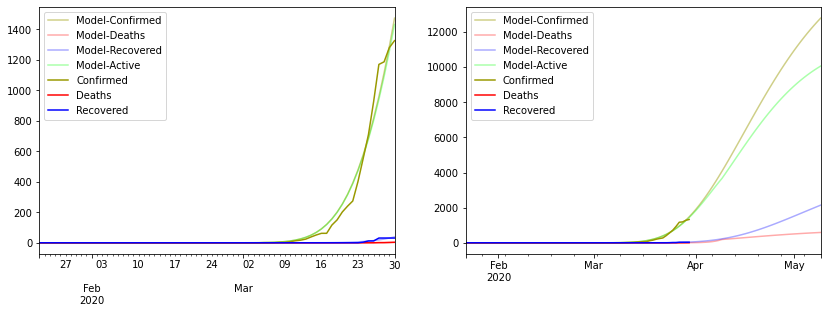

Spain COVID-19 Prediction


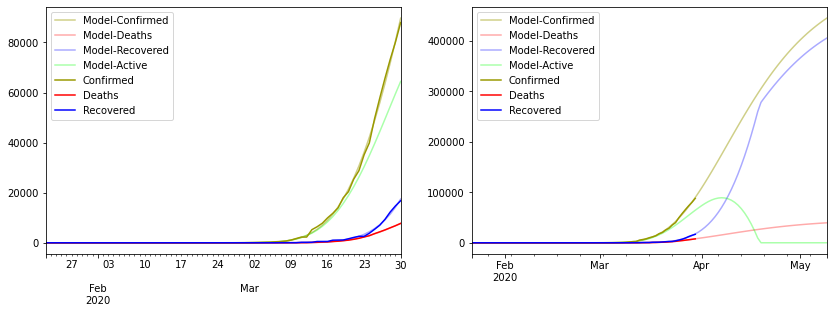

Sweden COVID-19 Prediction


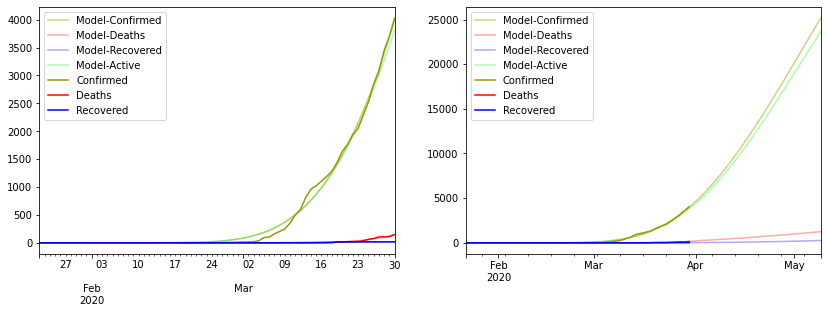

Switzerland COVID-19 Prediction


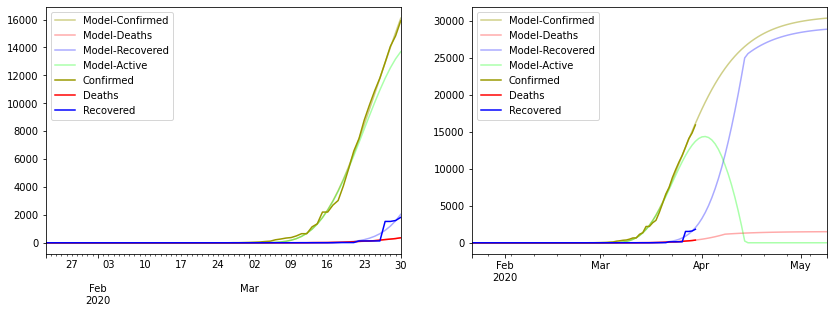

Thailand COVID-19 Prediction


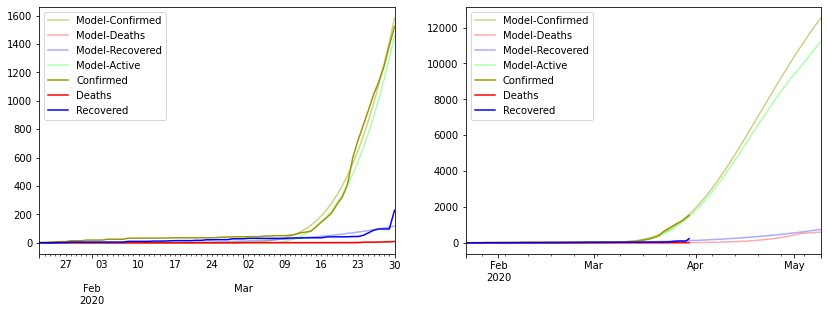

Turkey COVID-19 Prediction


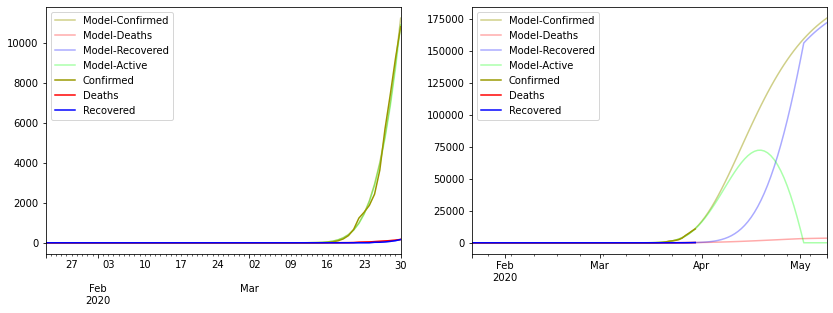

United Kingdom COVID-19 Prediction


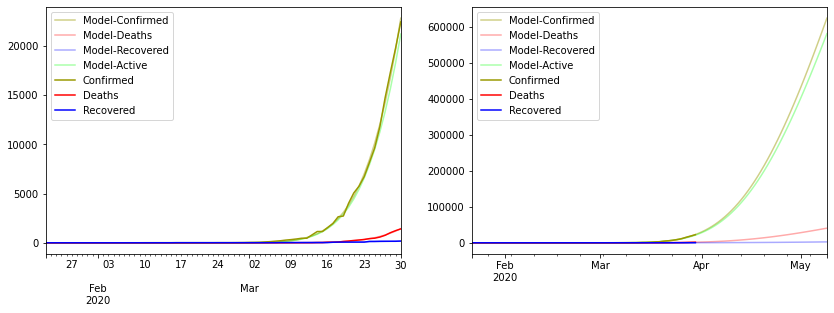

US COVID-19 Prediction


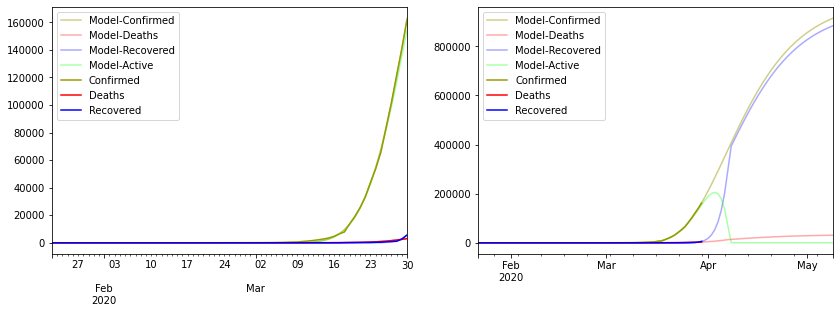

In [164]:
# All Country Confirmed Greater than 1000

stats = []
for country in full_table['Country/Region'].unique():
# for country in ['Sweden']:
    df = get_time_series(country)
    # only consider countries with at least 1000 cases (plus Sweden)
    if len(df) == 0 or (max(df['Confirmed']) < 1000): 
        continue
    print('{} COVID-19 Prediction'.format(country))
    opt_display_model(df, stats)